# 10-9. 프로젝트: CAM을 만들고 평가해 보자

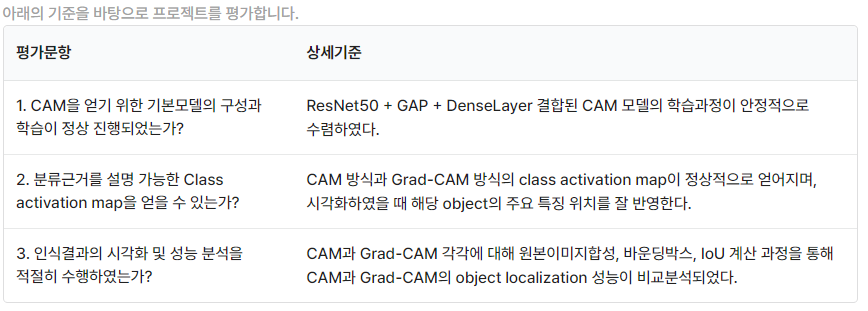

## 라이브러리 버전 확인하기
---
사용할 라이브러리 버전을 확인해봐요.

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import PIL

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.6.0
1.19.5
4.5.3
8.3.2


In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

print('슝=3')

슝=3


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 데이터 불러오기

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs', 
    split = ['train', 'test'],
    shuffle_files = True, 
    with_info = True
    )

print('Got it!!')

Got it!!


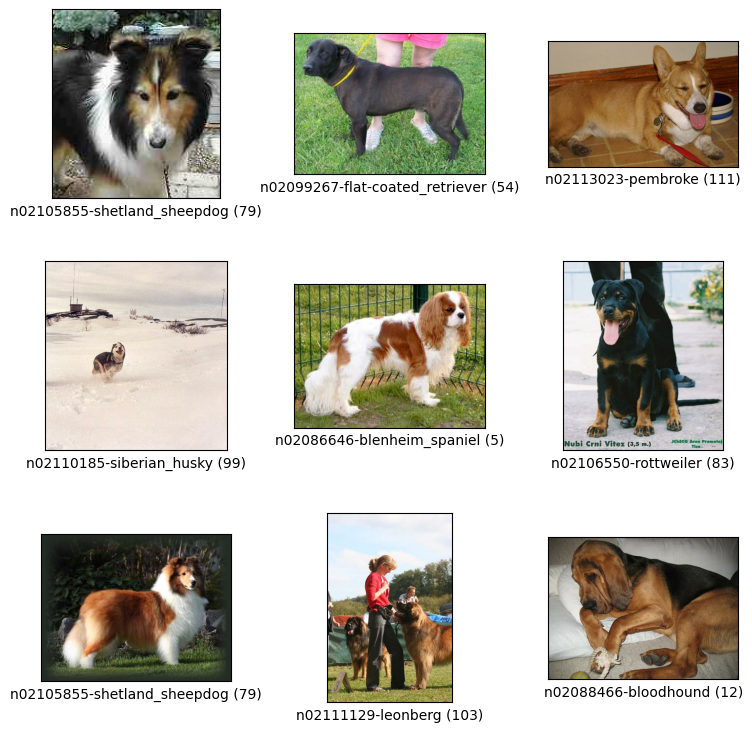

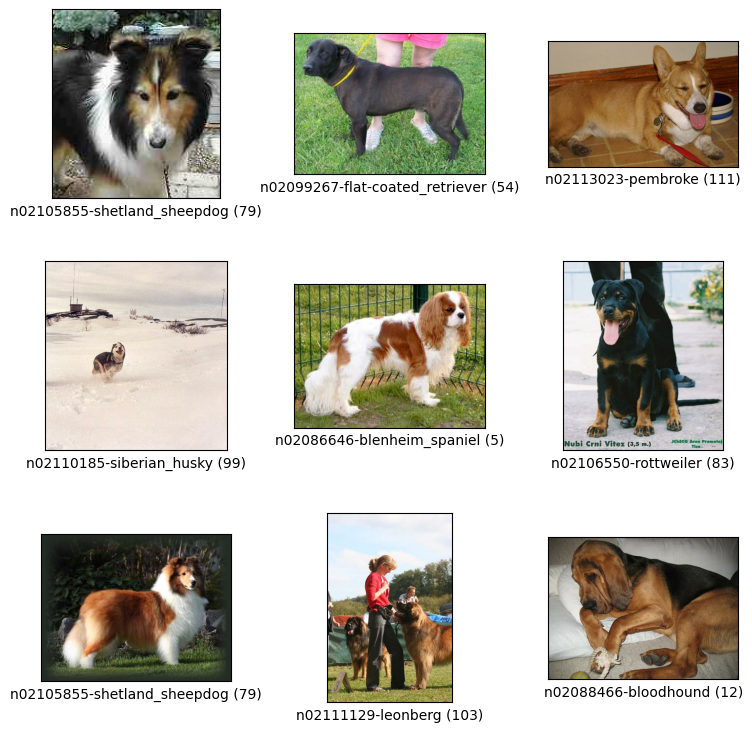

In [5]:
tfds.show_examples(ds_train, ds_info)

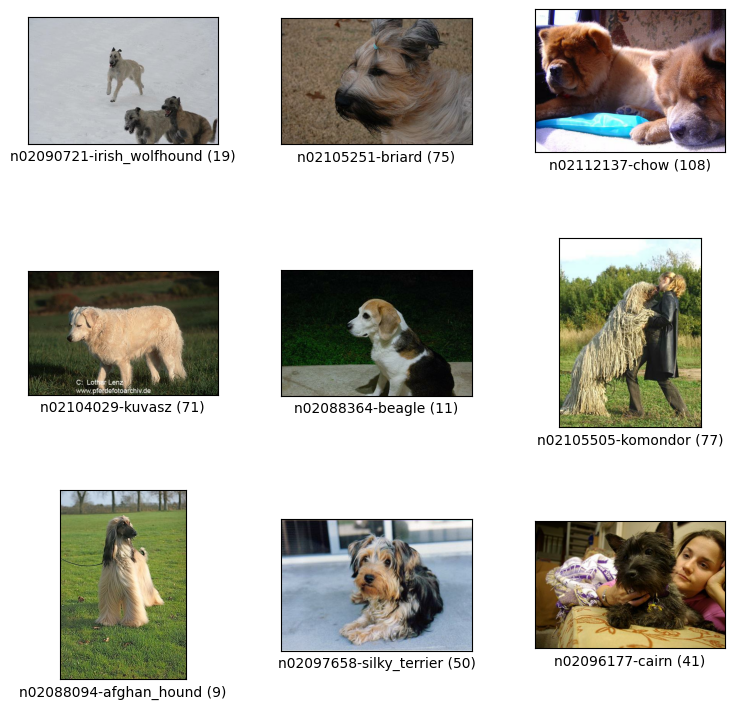

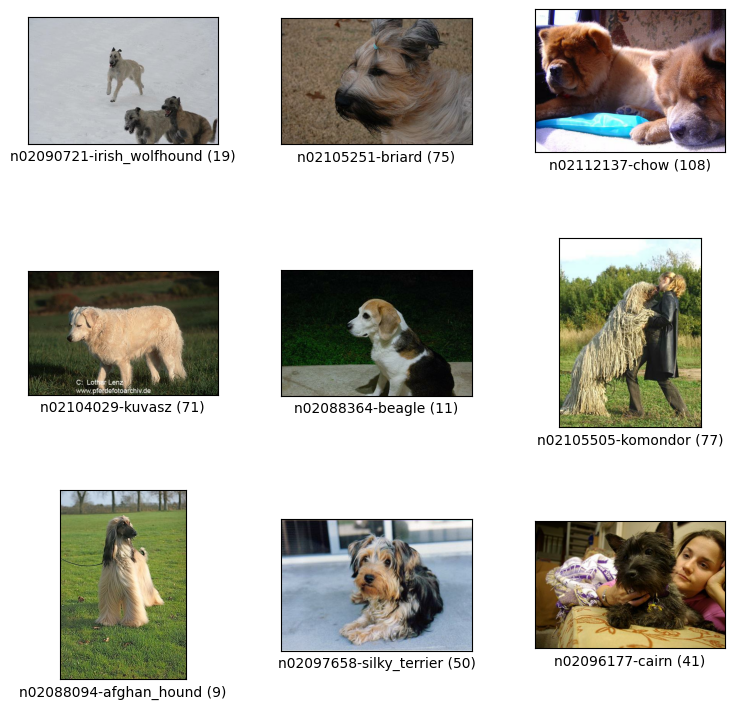

In [6]:
tfds.show_examples(ds_test, ds_info)

## CAM 구현하기
----

1. 이번 노드에 나왔던 CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

```python
def generate_cam(model, item):
    cam_image = None
    # TODO: generate cam image
    return cam_image
```

### 1) CAM을 위한 모델 만들기

In [7]:
ds_info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around
    the world. This dataset has been built using images and annotation from
    ImageNet for the task of fine-grained image categorization. There are
    20,580 images, out of which 12,000 are used for training and 8580 for
    testing. Class labels and bounding box annotations are provided
    for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_path='C:\\Users\\aeoli\\tensorflow_datasets\\stanford_dogs\\0.2.0',
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox':

In [8]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [9]:
num_classes = ds_info.features['label'].num_classes

In [10]:
# functional API 활용하여 모델 작성

base_model = keras.applications.resnet50.ResNet50(
    include_top = False, #fully connected layer 제거
    weights = 'imagenet', 
    input_shape = (224, 224, 3),
    pooling = 'avg' # include_top = False 일때만 설정가능함. GAP를 위해 avg pooling 설정
    )

x = base_model.output
preds = keras.layers.Dense(num_classes, activation = 'softmax')(x)
cam_model01 = keras.Model(inputs = base_model.input, outputs = preds)

In [11]:
cam_model01.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

### 2) CAM모델을 위한 데이터 전처리 Pipeline 만들기

In [10]:
def normalize_and_resize_img(input):
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test = False, batch_size = 16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls = 4  # 멀티태스킹 인수
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

print('Got It!!!')

Got It!!!


In [11]:
# 데이터셋에 전처리와 배치처리 적용
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


### 3) 모델 훈련

In [14]:
cam_model01.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01),
                 metrics = ['accuracy'],)

print('Got It!!')

Got It!!


In [15]:
# history_cam_model01 = cam_model01.fit(
#     ds_train_norm,
#     steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
#     validation_steps = int(ds_info.splits['test'].num_examples/16),
#     epochs = 20,
#     validation_data = ds_test_norm,
#     verbose = 1,
#     use_multiprocessing = True,)

In [12]:
import os

cam_model01_path = r'C:\12\coding_data\going_deeper\gd10\models\cam_model01.h5'

In [17]:
# cam_model01.save(cam_model01_path)

print('Got It!!')

Got It!!


In [ ]:
history_cammodel01_df = pd.DataFrame(history_cam_model01.history)
history_cammodel01_df.to_csv(r'C:\12\coding_data\going_deeper\gd10\histiory\cam01_history.csv', index = False)

In [ ]:
history_cammodel01_df

In [20]:
history_cammodel01_df = pd.read_csv(r'C:\12\coding_data\going_deeper\gd10\histiory\cam01_history.csv')

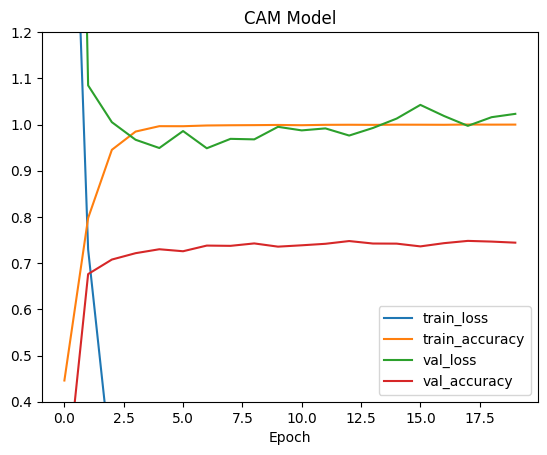

In [21]:
plt.plot(history_cammodel01_df['loss'], label='train_loss')
plt.plot(history_cammodel01_df['accuracy'], label='train_accuracy')
plt.plot(history_cammodel01_df['val_loss'], label='val_loss')
plt.plot(history_cammodel01_df['val_accuracy'], label='val_accuracy')

plt.xlabel('Epoch')
plt.title('CAM Model')
plt.ylim(0.4 , 1.2)
plt.legend()

plt.show()

In [ ]:
del cam_model01
del history_cam_model01
del history_cammodel01_df

2. 만든 함수로 CAM 이미지를 생성합시다.


```python
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
```

### 4) CAM 이미지 그리기

#### 1) 모델불러오기

In [13]:
cam_model01 = tf.keras.models.load_model(cam_model01_path)
print('Got It!!')

Got It!!


#### 2) 이미지 불러오기

In [14]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    
    return sample_data[0]

67


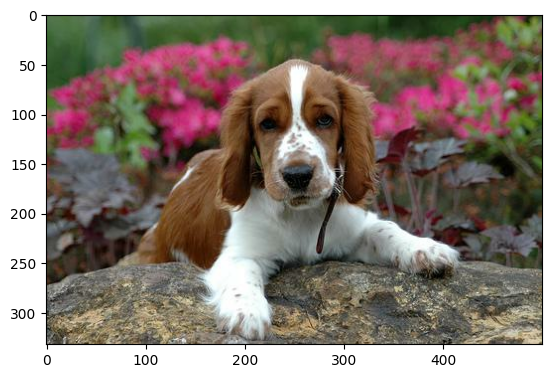

In [25]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [26]:
normalize_and_resize_img

<function __main__.normalize_and_resize_img(input)>

#### 3) CAM이미지 생성

In [15]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    print('width:', width, 'height:', height) # 
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    print('image tensor shape: ', img_tensor.shape) #
    
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    # tf.keras.models.Model([input], [1st output, 2nd output])
    # https://www.tensorflow.org/api_docs/python/tf/keras/Model
    conv_outputs, prediction = cam_model(tf.expand_dims(img_tensor, 0))
    print('tf.expand_dims:', tf.expand_dims(img_tensor, 0).shape) #
    conv_outputs = conv_outputs[0, :, :, :]
    
    class_weights = model.layers[-1].get_weights()[0]
    
    cam_image = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
    print('cam image shape:', cam_image.shape) #
    for i, w in enumerate(class_weights[:, class_idx]):
        #print(f'{i}th class weight:', w) #
        cam_image += w * conv_outputs[:, :, i]
    
    cam_image /= np.max(cam_image) #activation score를 normalize
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))
    print('cam image shape:', cam_image.shape) #
    
    return cam_image

print('Got It!!')

Got It!!


width: 500 height: 332
image tensor shape:  (224, 224, 3)
tf.expand_dims: (1, 224, 224, 3)
cam image shape: (7, 7)
cam image shape: (332, 500)


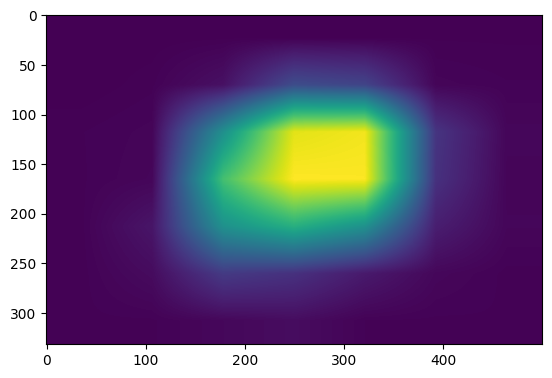

In [28]:
cam_image = generate_cam(cam_model01, item)
plt.imshow(cam_image)
plt.show()

#### 4) CAM이미지와 원본이미지 합성

In [29]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

print('슝=3')

슝=3


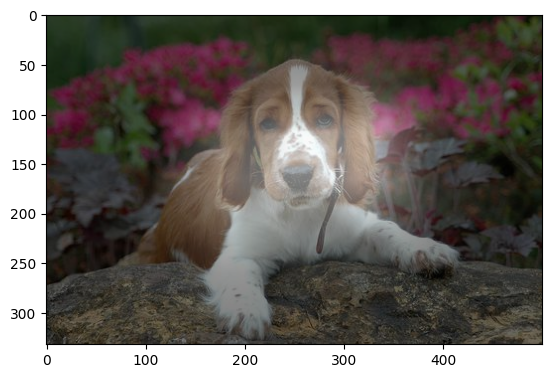

In [30]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

3. 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수를 만들어보세요.


- [webnautes님의 OpenCV Python 강좌 - 두 개의 이미지 더하기, 블렌딩](https://webnautes.tistory.com/1245|)

```python
def visualize_cam_on_image(image, cam_image):
    # TODO: blend image
    merged_image = None
    return merged_image
```

<br/>
<br/>

```python
# visualize_cam_on_image() 함수 사용

type(item['image'].numpy())

origin_image = item['image'].numpy().astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
```

## Grad-CAM 구현하기
---
1. 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.


```python
def generate_grad_cam(model, activation_layer, item):
    grad_cam_image = None
    # TODO: generate grad_cam_image

    return grad_cam_image
```

### 1) Grad-CAM 시각화 함수 구현

In [16]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print('슝=3')


슝=3


- 그래디언트 테이프 소개([링크](https://www.tensorflow.org/guide/autodiff?hl=ko))
- GradientTape 활용법([링크](https://teddylee777.github.io/tensorflow/gradient-tape/))

### 2) 각 Layer output weight 시각화

2. 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.

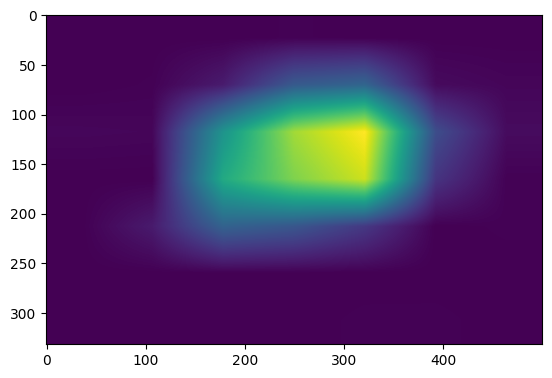

In [32]:
grad_cam_image = generate_grad_cam(cam_model01, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

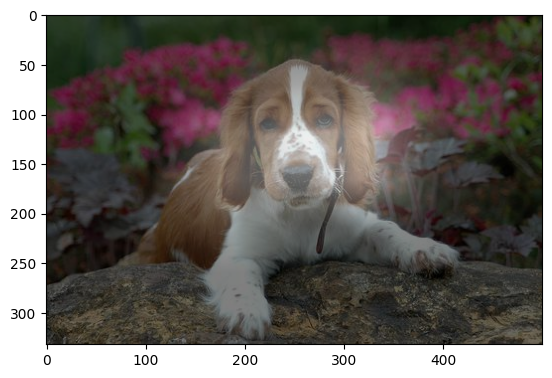

In [33]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

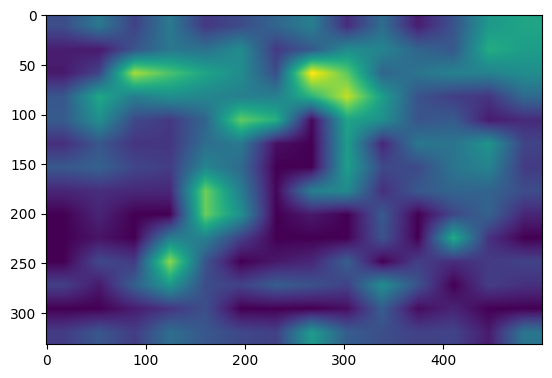

In [34]:
grad_cam_image = generate_grad_cam(cam_model01, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

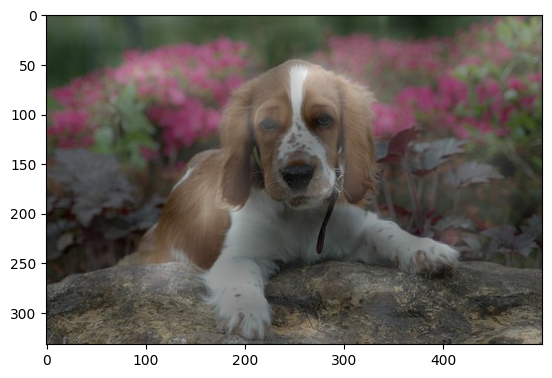

In [35]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

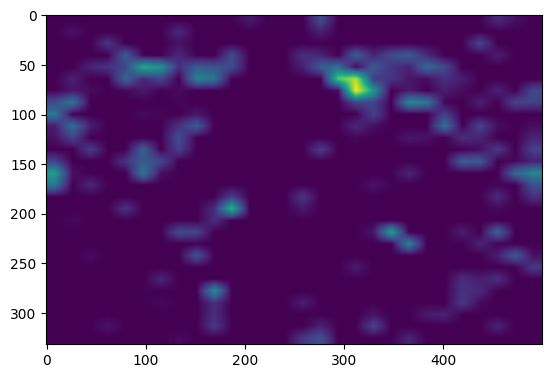

In [36]:
grad_cam_image = generate_grad_cam(cam_model01, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

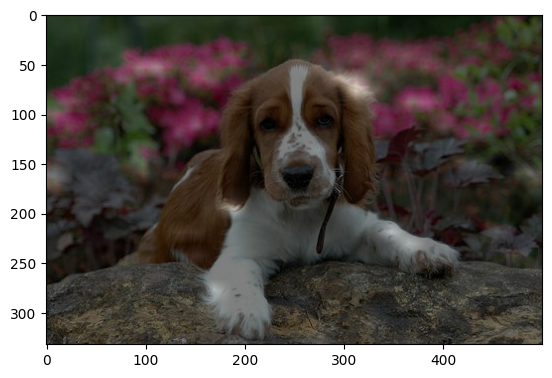

In [37]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

3. 위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화해 보세요.

## 바운딩 박스 구하기
----
### 1) 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.

84


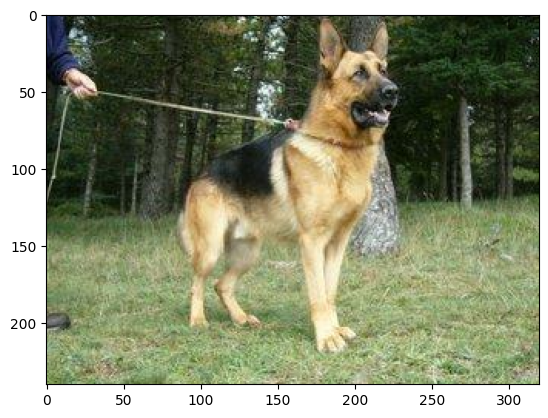

In [38]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

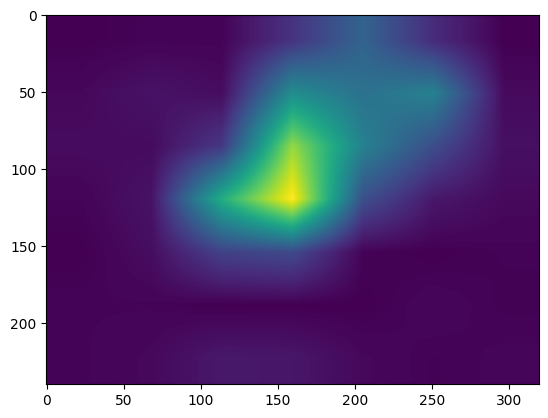

In [39]:
grad_cam_image = generate_grad_cam(cam_model01, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [21]:
def get_bbox(cam_image, score_thresh=0.07):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

print('슝=3')

슝=3


In [41]:
rect = get_bbox(grad_cam_image)
rect

array([[ 70,   0],
       [291,   0],
       [291, 177],
       [ 70, 177]], dtype=int64)

### 2) 1)에서 얻은 바운딩 박스를 시각화해 보세요.

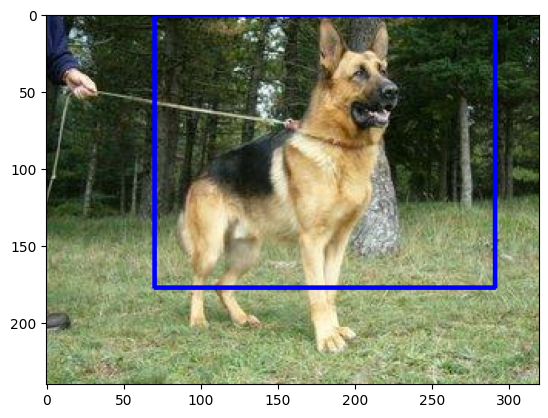

In [42]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

## IoU 구하기
---
### 1) 정답 바운딩 박스(ground truth) 와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요.


```python
def get_iou(gt_bbox, pred_bbox):
    iou = None
    # TODO: get iou between two bbox
    return iou
```

In [22]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

print('슝=3')

슝=3


In [45]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.0, 0.21875, 0.7375, 0.909375]

In [46]:
item['objects']['bbox']

array([[0.     , 0.23125, 0.925  , 0.73125]], dtype=float32)

In [23]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

print('슝=3')

슝=3


In [48]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.6114385586308622

### 2) CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.

11


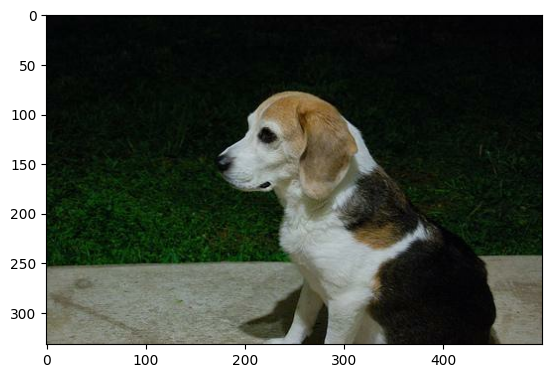

In [18]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

#### ① CAM을 통한 바운딩 박스 구하기

width: 500 height: 332
image tensor shape:  (224, 224, 3)
tf.expand_dims: (1, 224, 224, 3)
cam image shape: (7, 7)
cam image shape: (332, 500)


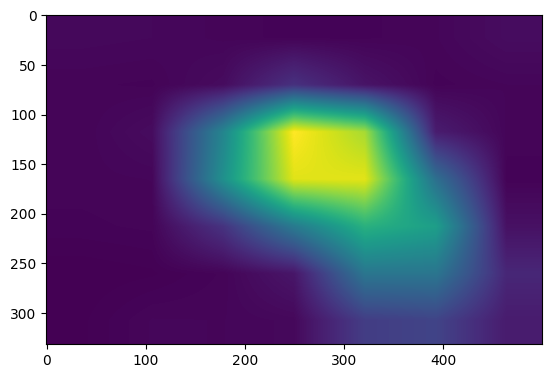

In [19]:
cam_image = generate_cam(cam_model01, item)
plt.imshow(cam_image)
plt.show()

In [24]:
rect = get_bbox(cam_image)
rect

array([[ 71, 155],
       [238, -37],
       [557, 238],
       [390, 431]], dtype=int64)

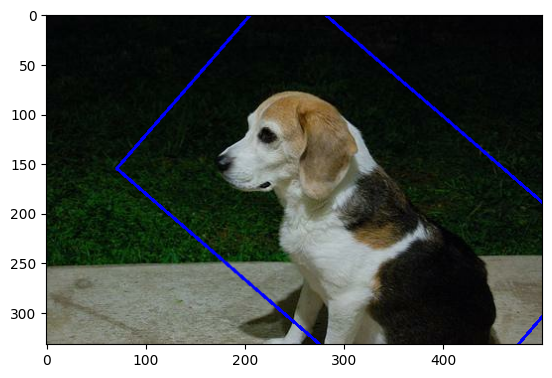

In [25]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

#### ② CAM을 통한 바운딩 박스 IoU 구하기

In [27]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.11144578313253012, 0.142, 1.2981927710843373, 1.114]

In [28]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.33073497322323425

#### ③ Grad-CAM을 통한 바운딩 박스 구하기

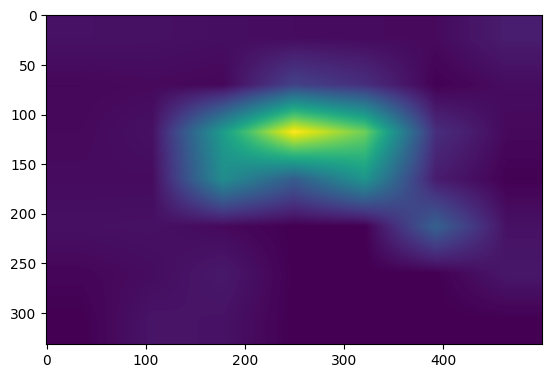

In [29]:
grad_cam_image = generate_grad_cam(cam_model01, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [30]:
rect = get_bbox(grad_cam_image)
rect

array([[ 96, 197],
       [129,   8],
       [482,  70],
       [449, 259]], dtype=int64)

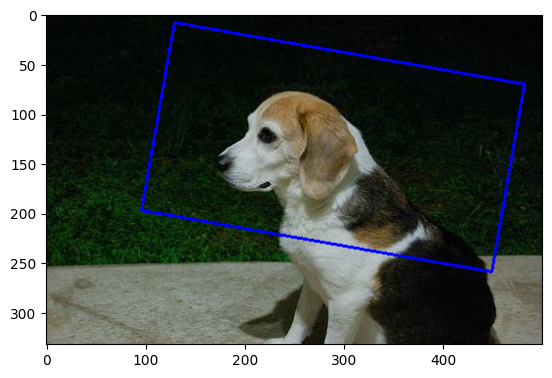

In [31]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

#### ④ Grad-CAM을 통해 구한 Bbox IoU구하기

In [32]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.024096385542168676, 0.192, 0.7801204819277109, 0.964]

In [33]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.46432582618510504

# 회고

### 신경쓴점
- 파이썬으로 작성된 코드의 진행상황을 디테일하게 살피면서 과제를 진행했다. 
- LMS코드를 바탕으로 오류없이 진행되도록 진행했다. 

### 아쉬운점
- 모델의 성능을 좀더 끌어올리고 싶다. 
- CAM 이미지로 작성한 바운딩박스의 IoU을 좀더 높이고 싶다. 

### 확인한점
- 시각적으로 보면 CAM모델이 Grad-CAM모델에 비해 더 바운딩박스를 잘 그린거 같지만, IoU수치는 Grad-CAM이 더 잘 그린것으로 판단하고 있다. 

### reference
- LMS